In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import Sequence

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [4]:
img_size=224
batch_size=32

In [5]:
from tensorflow import keras
base_model = keras.applications.MobileNetV2(
    weights= 'imagenet',
    input_shape=(img_size, img_size, 3),
    include_top= False
)


## Freeze Base Model

In [6]:
# Freeze base model
base_model.trainable = False


## Add Layers to Model

In [7]:
# Create inputs with correct shape
inputs = keras.Input(shape=(img_size, img_size, 3))  # Adjust the shape as needed

# Pass inputs through the base model
x = base_model(inputs, training=False)


# Add Global Average Pooling Layer
x = keras.layers.GlobalMaxPooling2D()(x)  

x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Dense(64,activation='relu')(x)

x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Dense(64,activation='relu')(x)

x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Dense(64,activation='relu')(x)

kernal_regularizer = keras.regularizers.L2(l2=0.01)

# Add final dense layer
num_classes = 6  # Set the number of classes (types of fruit) you have
outputs = keras.layers.Dense(num_classes, activation='softmax',kernel_regularizer=kernal_regularizer)(x)

# Combine inputs and outputs to create the model
model = keras.Model(inputs, outputs)

# Print model summary to check the architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0     

## Augment the Data

In [ ]:
class MergedGenerators(Sequence):
    def __init__(self, generators):
        self.generators = generators
        self.lengths = [len(gen) for gen in generators]
        self.cumulative_lengths = np.cumsum(self.lengths)

    def __len__(self):
        return self.cumulative_lengths[-1]

    def __getitem__(self, index):
        generator_index = np.argmax(index < self.cumulative_lengths)
        if generator_index > 0:
            sample_index = index - self.cumulative_lengths[generator_index - 1]
        else:
            sample_index = index

        # Get the data and labels from the corresponding generator
        data, labels = self.generators[generator_index][sample_index]
        return data, labels

In [ ]:
def grayscale_conversion(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Repeat the single channel across three channels
    grayscale_image = np.stack((grayscale_image,) * 3, axis=-1)
    return grayscale_image

In [ ]:
normal_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)
noisy_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=lambda x: x + np.random.normal(0, 0.1, x.shape),  # Add noise
)
shaded_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    brightness_range=[0.5, 1.5],  # Adjust the range for shading
)
grayscale_datagen = ImageDataGenerator(
    preprocessing_function= grayscale_conversion,
    rescale=1.0 / 255,
)

In [9]:
new_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
)
train_data_dir = r"C:\Users\Acer\Desktop\Minor Project\Split\train"
new_generator = new_gen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=25,
    class_mode='categorical'
)

Found 10911 images belonging to 6 classes.


In [ ]:
train_data_dir = r"C:\Users\Acer\Desktop\Minor Project\Split\train"
validation_data_dir = r"C:\Users\Acer\Desktop\Minor Project\Split\val"
generator1 = normal_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=11,
    class_mode='categorical'
)
generator2 = shaded_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    class_mode='categorical'
)
generator3 = noisy_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=43,
    class_mode='categorical'
)
generator4 = grayscale_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=44,
    class_mode='categorical'
)

In [10]:
validation_data_dir = r"C:\Users\Acer\Desktop\Minor Project\Split\val"
valgenerator = ImageDataGenerator(
    rescale=1.0 / 255,
)
generator5 = valgenerator.flow_from_directory(
    validation_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=86,
    class_mode='categorical'
)

Found 3000 images belonging to 6 classes.


In [ ]:
combined_generator = MergedGenerators([generator1, generator2, generator3, generator4])
combined_generator = MergedGenerators([generator1, generator2])

## Train the Model

In [ ]:
#history=model.fit(x = combined_generator, validation_data = generator5, epochs = 2)

In [11]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [12]:
base_model.trainable = True
fine_tune_at = 152

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
  
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0     

                                                                 
Total params: 2,348,678
Trainable params: 93,254
Non-trainable params: 2,255,424
_________________________________________________________________


In [ ]:
#base_model.trainable = False
#model.summary()

In [13]:
# Compile the model with a low learning rate
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.00001),  # Adjust the learning rate as needed
    loss='categorical_crossentropy',  # For multi-class classification
    metrics=['accuracy'],
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0     

Total params: 2,348,678
Trainable params: 93,254
Non-trainable params: 2,255,424
_________________________________________________________________


In [15]:
callbacks=keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=1,
    min_delta=0.01
)

In [16]:
history=model.fit(x = new_generator, validation_data = generator5, epochs = 20, callbacks=[callbacks])

Epoch 1/20
341/341 [==============================] - 147s 408ms/step - loss: 3.1833 - accuracy: 0.1809 - val_loss: 1.7806 - val_accuracy: 0.3077
Epoch 2/20
341/341 [==============================] - 139s 407ms/step - loss: 2.1446 - accuracy: 0.2375 - val_loss: 1.5831 - val_accuracy: 0.4063
Epoch 3/20
341/341 [==============================] - 145s 424ms/step - loss: 1.8519 - accuracy: 0.2958 - val_loss: 1.4692 - val_accuracy: 0.4717
Epoch 4/20
341/341 [==============================] - 142s 415ms/step - loss: 1.6948 - accuracy: 0.3543 - val_loss: 1.3554 - val_accuracy: 0.5400
Epoch 5/20
341/341 [==============================] - 131s 383ms/step - loss: 1.5787 - accuracy: 0.4033 - val_loss: 1.2410 - val_accuracy: 0.5943
Epoch 6/20
341/341 [==============================] - 140s 409ms/step - loss: 1.4835 - accuracy: 0.4415 - val_loss: 1.1394 - val_accuracy: 0.6107
Epoch 7/20
341/341 [==============================] - 129s 380ms/step - loss: 1.3990 - accuracy: 0.4640 - val_loss: 1.0501 -

In [17]:
model.save("New models\model16.h5")

In [19]:
history1=model.fit(x = new_generator, validation_data = generator5, epochs = 20, callbacks=[callbacks])

Epoch 1/20
341/341 [==============================] - 133s 390ms/step - loss: 0.8048 - accuracy: 0.7090 - val_loss: 0.5163 - val_accuracy: 0.8713
Epoch 2/20
341/341 [==============================] - 136s 399ms/step - loss: 0.7829 - accuracy: 0.7237 - val_loss: 0.4967 - val_accuracy: 0.8757
Epoch 3/20
341/341 [==============================] - 134s 394ms/step - loss: 0.7403 - accuracy: 0.7378 - val_loss: 0.4716 - val_accuracy: 0.8850
Epoch 4/20
341/341 [==============================] - 134s 394ms/step - loss: 0.7378 - accuracy: 0.7367 - val_loss: 0.4520 - val_accuracy: 0.8890
Epoch 5/20
341/341 [==============================] - 144s 423ms/step - loss: 0.7077 - accuracy: 0.7474 - val_loss: 0.4325 - val_accuracy: 0.8963
Epoch 6/20
341/341 [==============================] - 153s 448ms/step - loss: 0.6881 - accuracy: 0.7624 - val_loss: 0.4106 - val_accuracy: 0.9040
Epoch 7/20
341/341 [==============================] - 155s 454ms/step - loss: 0.6656 - accuracy: 0.7716 - val_loss: 0.3928 -

In [20]:
model.save("New models\model17.h5")

In [25]:
history2=model.fit(x = new_generator, validation_data = generator5, epochs = 20, callbacks=[callbacks])

Epoch 1/20
341/341 [==============================] - 139s 406ms/step - loss: 0.4745 - accuracy: 0.8572 - val_loss: 0.2346 - val_accuracy: 0.9590
Epoch 2/20
341/341 [==============================] - 145s 425ms/step - loss: 0.4672 - accuracy: 0.8614 - val_loss: 0.2273 - val_accuracy: 0.9650
Epoch 3/20
341/341 [==============================] - 160s 468ms/step - loss: 0.4567 - accuracy: 0.8609 - val_loss: 0.2233 - val_accuracy: 0.9637
Epoch 4/20
341/341 [==============================] - 148s 434ms/step - loss: 0.4427 - accuracy: 0.8679 - val_loss: 0.2139 - val_accuracy: 0.9687
Epoch 5/20
341/341 [==============================] - 146s 427ms/step - loss: 0.4524 - accuracy: 0.8643 - val_loss: 0.2099 - val_accuracy: 0.9687
Epoch 6/20
341/341 [==============================] - 143s 420ms/step - loss: 0.4373 - accuracy: 0.8682 - val_loss: 0.2041 - val_accuracy: 0.9703
Epoch 7/20
341/341 [==============================] - 141s 412ms/step - loss: 0.4276 - accuracy: 0.8718 - val_loss: 0.1977 -

In [27]:
model.save("New models\model18.h5")

In [33]:
history3=model.fit(x = new_generator, validation_data = generator5, epochs = 20, callbacks=[callbacks])

Epoch 1/20
341/341 [==============================] - 198s 581ms/step - loss: 0.4008 - accuracy: 0.8868 - val_loss: 0.1863 - val_accuracy: 0.9740
Epoch 2/20
341/341 [==============================] - 141s 414ms/step - loss: 0.3836 - accuracy: 0.8876 - val_loss: 0.1792 - val_accuracy: 0.9773
Epoch 3/20
341/341 [==============================] - 137s 403ms/step - loss: 0.3780 - accuracy: 0.8900 - val_loss: 0.1741 - val_accuracy: 0.9773
Epoch 4/20
341/341 [==============================] - 138s 405ms/step - loss: 0.3746 - accuracy: 0.8938 - val_loss: 0.1717 - val_accuracy: 0.9767
Epoch 5/20
341/341 [==============================] - 146s 429ms/step - loss: 0.3733 - accuracy: 0.8953 - val_loss: 0.1682 - val_accuracy: 0.9790
Epoch 5: early stopping


In [42]:
model.save("New models\model19.h5")

In [45]:
callbacks=keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=1,
    min_delta=0.05
)

In [46]:
history4=model.fit(x = new_generator, validation_data = generator5, epochs = 20, callbacks=[callbacks])

Epoch 1/20
341/341 [==============================] - 129s 376ms/step - loss: 0.3378 - accuracy: 0.9070 - val_loss: 0.1538 - val_accuracy: 0.9813
Epoch 2/20
341/341 [==============================] - 144s 423ms/step - loss: 0.3373 - accuracy: 0.9112 - val_loss: 0.1523 - val_accuracy: 0.9800
Epoch 3/20
341/341 [==============================] - 151s 441ms/step - loss: 0.3352 - accuracy: 0.9075 - val_loss: 0.1500 - val_accuracy: 0.9823
Epoch 4/20
341/341 [==============================] - 161s 471ms/step - loss: 0.3333 - accuracy: 0.9083 - val_loss: 0.1480 - val_accuracy: 0.9813
Epoch 4: early stopping


In [49]:
callbacks=keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=1,
    min_delta=0.005
)

In [50]:
history5=model.fit(x = new_generator, validation_data = generator5, epochs = 20, callbacks=[callbacks])

Epoch 1/20
341/341 [==============================] - 153s 447ms/step - loss: 0.3243 - accuracy: 0.9112 - val_loss: 0.1451 - val_accuracy: 0.9820
Epoch 2/20
341/341 [==============================] - 151s 444ms/step - loss: 0.3206 - accuracy: 0.9135 - val_loss: 0.1429 - val_accuracy: 0.9833
Epoch 3/20
341/341 [==============================] - 151s 443ms/step - loss: 0.3185 - accuracy: 0.9154 - val_loss: 0.1412 - val_accuracy: 0.9843
Epoch 4/20
341/341 [==============================] - 150s 440ms/step - loss: 0.3139 - accuracy: 0.9153 - val_loss: 0.1397 - val_accuracy: 0.9847
Epoch 5/20
341/341 [==============================] - 156s 457ms/step - loss: 0.3104 - accuracy: 0.9157 - val_loss: 0.1394 - val_accuracy: 0.9843
Epoch 6/20
341/341 [==============================] - 145s 426ms/step - loss: 0.2968 - accuracy: 0.9221 - val_loss: 0.1362 - val_accuracy: 0.9857
Epoch 7/20
341/341 [==============================] - 157s 461ms/step - loss: 0.2988 - accuracy: 0.9207 - val_loss: 0.1354 -

In [51]:
model.save("New models\model20.h5")

In [52]:
callbacks=keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=1,
    min_delta=0.001
)

In [53]:
history5=model.fit(x = new_generator, validation_data = generator5, epochs = 20, callbacks=[callbacks])

Epoch 1/20
341/341 [==============================] - 156s 457ms/step - loss: 0.2945 - accuracy: 0.9236 - val_loss: 0.1331 - val_accuracy: 0.9857
Epoch 2/20
341/341 [==============================] - 132s 386ms/step - loss: 0.2925 - accuracy: 0.9246 - val_loss: 0.1317 - val_accuracy: 0.9850
Epoch 3/20
341/341 [==============================] - 135s 395ms/step - loss: 0.2945 - accuracy: 0.9257 - val_loss: 0.1293 - val_accuracy: 0.9860
Epoch 4/20
341/341 [==============================] - 134s 394ms/step - loss: 0.2855 - accuracy: 0.9276 - val_loss: 0.1261 - val_accuracy: 0.9870
Epoch 5/20
341/341 [==============================] - 142s 417ms/step - loss: 0.2833 - accuracy: 0.9255 - val_loss: 0.1263 - val_accuracy: 0.9863
Epoch 6/20
341/341 [==============================] - 155s 454ms/step - loss: 0.2738 - accuracy: 0.9325 - val_loss: 0.1239 - val_accuracy: 0.9877
Epoch 7/20
341/341 [==============================] - 156s 457ms/step - loss: 0.2803 - accuracy: 0.9315 - val_loss: 0.1234 -

In [56]:
model.save("New models\model21.h5")

In [54]:
# Combine training loss
combined_loss = history.history['loss'] + history1.history['loss'] + history2.history['loss'] + history3.history['loss'] + history4.history['loss'] + history5.history['loss']

# Combine validation loss
combined_val_loss = history.history['val_loss'] + history1.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'] + history4.history['val_loss'] + history5.history['val_loss']

# Combine training accuracy
combined_acc = history.history['accuracy'] + history1.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy'] + history4.history['accuracy'] + history5.history['accuracy']

# Combine validation accuracy
combined_val_acc = history.history['val_accuracy'] + history1.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy'] + history4.history['val_accuracy'] + history5.history['val_accuracy']

# Now you have the combined history values up to history5


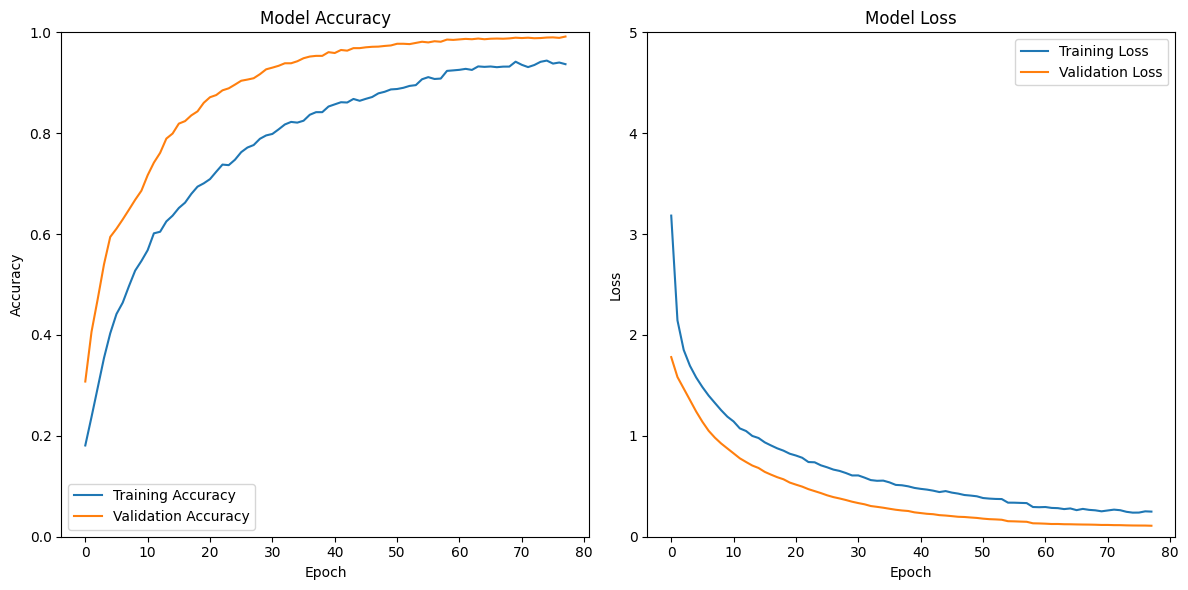

In [55]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(combined_acc, label='Training Accuracy')
plt.plot(combined_val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(combined_loss, label='Training Loss')
plt.plot(combined_val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 5.0)
plt.legend()
# Show the plots
plt.tight_layout()
plt.show()

## Evaluate the Model

Found 3000 images belonging to 6 classes.
47/47 [==============================] - 9s 186ms/step
F1 Score: 0.9917


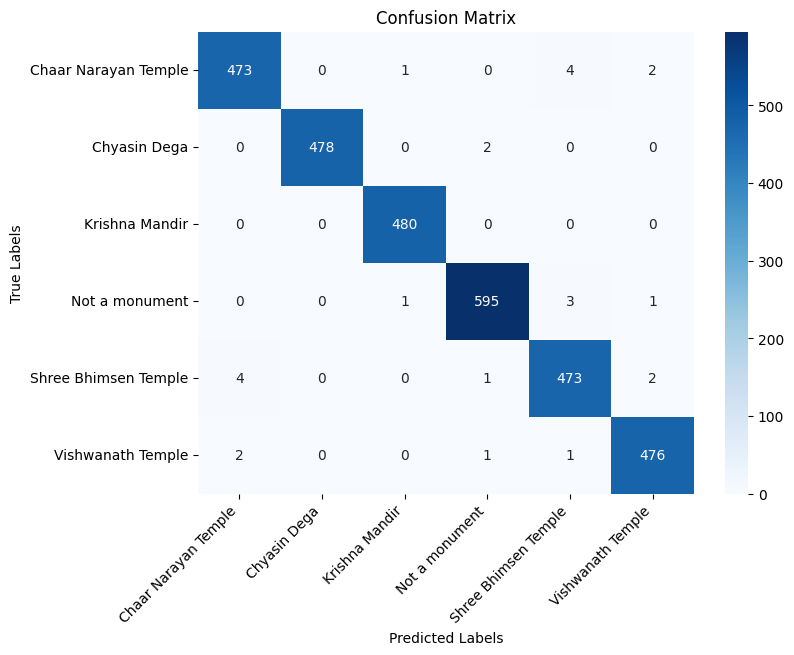

In [57]:
import cv2
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
img_size = 224
batch_size=64
# Load the pre-trained model
#model_path = r'C:\Users\Acer\Desktop\Minor Project\New models\model12.1.h5'
#model = load_model(model_path)

# Set the path to your test dataset
test_data_dir = r'C:\Users\Acer\Desktop\Minor Project\Split\val'

# Data Preprocessing for testing set
test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)  # Ensure labels are in the same order as predictions

# Get true labels
true_labels = test_generator.classes

# Make predictions
predictions = model.predict(test_generator)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display F1 score
print(f"F1 Score: {f1:.4f}")

# Display Confusion Matrix with rotated x-axis labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices, cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.show()


In [58]:
import tensorflow as tf
import cv2
import numpy as np
from keras.preprocessing import image

# Load the trained model
#model = tf.keras.models.load_model(r'C:\Users\Acer\Desktop\Minor Project\New models\model11.h5')

# Path to the single image you want to predict

class_names = ['Chaar Narayan Temple', 'Chyasin Dega', 'Krishna Mandir','Not a Monument', 'Shree Bhimsen Temple', 'Vishwanath Temple']

import numpy as np
from PIL import Image

# Load the image using a suitable image library
img = Image.open(r"C:\Users\Acer\Desktop\vishwanath02.jpg").convert('RGB')

# Resize the image to match the model's input dimensions
img = img.resize((img_size, img_size))  # Assuming model expects 128x128 images

# Convert the image to a NumPy array
img_array = np.array(img)

# Normalize pixel values to [0, 1] range (if model expects that)
img_array = img_array / 255.0

# Expand dimensions to create a batch of 1 image
img_batch = np.expand_dims(img_array, axis=0)

# Pass the image batch through the model
predictions = model.predict(img_batch)

# Extract the predicted probabilities for each class
probabilities = predictions[0]  # Access the probabilities for the first (and only) image
print(probabilities)

# ...

# Print class names along with predicted probabilities
for class_name, probability in zip(class_names, probabilities):
    probability_percentage = probability * 100
    print(f"{class_name}: {probability_percentage:.2f}%")
# ...

1/1 [==============================] - 0s 70ms/step
[0.04016998 0.00252589 0.00850423 0.00678583 0.08306863 0.85894537]
Chaar Narayan Temple: 4.02%
Chyasin Dega: 0.25%
Krishna Mandir: 0.85%
Not a Monument: 0.68%
Shree Bhimsen Temple: 8.31%
Vishwanath Temple: 85.89%


In [ ]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
#model_path = r'C:\Users\Acer\Desktop\Minor Project\New models\model6.h5'
#model = load_model(model_path)

test_data_dir = r'C:\Users\Acer\Desktop\Minor Project\Split\test\Shree Bhimsen Temple'

IMAGE_SIZE=224
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(test_data_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type=tf.uint8
converter.inference_output_type=tf.uint8
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()
with open('model12.3_quantized.tflite', 'wb') as f:
  f.write(tflite_model)
  
interpreter=tf.lite.Interpreter(model_path='model12.3_quantized.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:",input_details[0]['shape'])
print("Input Type:",input_details[0]['dtype'])
print("Output Shape:",output_details[0]['shape'])
print("Output Type:",output_details[0]['dtype'])
"""Writes metadata and label file to the image classifier models."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow as tf
import flatbuffers
from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support import metadata as _metadata

# Define the paths to the model file, label file, and export directory
model_file = r"C:\Users\Acer\Desktop\Minor Project\model12.3_quantized.tflite"
label_file = r"C:\Users\Acer\Desktop\Minor Project\labels.txt"
export_directory = r"C:\Users\Acer\Desktop\Minor Project\model_with_metadata"

class ModelSpecificInfo(object):
    """Holds information that is specifically tied to an image classifier."""

    def __init__(self, name, version, image_width, image_height, image_min,
                image_max, mean, std, num_classes, author):
        self.name = name
        self.version = version
        self.image_width = image_width
        self.image_height = image_height
        self.image_min = image_min
        self.image_max = image_max
        self.mean = mean
        self.std = std
        self.num_classes = num_classes
        self.author = author

_MODEL_INFO = {
    "model12.3_quantized.tflite":
        ModelSpecificInfo(
            name="image classifier",
            version="v1",
            image_width=224,
            image_height=224,
            image_min=0,
            image_max=255,
            mean=[0],
            std=[255],
            num_classes=5,
            author="Aayush")
}


class MetadataPopulatorForImageClassifier(object):
    """Populates the metadata for an image classifier."""

    def __init__(self, model_file, model_info, label_file_path):
        self.model_file = model_file
        self.model_info = model_info
        self.label_file_path = label_file_path
        self.metadata_buf = None

    def populate(self):
        """Creates metadata and then populates it for an image classifier."""
        self._create_metadata()
        self._populate_metadata()

    def _create_metadata(self):
        """Creates the metadata for an image classifier."""

        # Creates model info.
        model_meta = _metadata_fb.ModelMetadataT()
        model_meta.name = self.model_info.name
        model_meta.description = ("Identify the most prominent object in the "
                                "image from a set of %d categories." %
                                self.model_info.num_classes)
        model_meta.version = self.model_info.version
        model_meta.author = self.model_info.author
        model_meta.license = ("Apache License. Version 2.0 "
                            "http://www.apache.org/licenses/LICENSE-2.0.")

        # Creates input info.
        input_meta = _metadata_fb.TensorMetadataT()
        input_meta.name = "image"
        input_meta.description = (
            "Input image to be classified. The expected image is {0} x {1}, with "
            "three channels (red, blue, and green) per pixel. Each value in the "
            "tensor is a single byte between {2} and {3}.".format(
                self.model_info.image_width, self.model_info.image_height,
                self.model_info.image_min, self.model_info.image_max))
        input_meta.content = _metadata_fb.ContentT()
        input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
        input_meta.content.contentProperties.colorSpace = (
            _metadata_fb.ColorSpaceType.RGB)
        input_meta.content.contentPropertiesType = (
            _metadata_fb.ContentProperties.ImageProperties)
        input_normalization = _metadata_fb.ProcessUnitT()
        input_normalization.optionsType = (
            _metadata_fb.ProcessUnitOptions.NormalizationOptions)
        input_normalization.options = _metadata_fb.NormalizationOptionsT()
        input_normalization.options.mean = self.model_info.mean
        input_normalization.options.std = self.model_info.std
        input_meta.processUnits = [input_normalization]
        input_stats = _metadata_fb.StatsT()
        input_stats.max = [self.model_info.image_max]
        input_stats.min = [self.model_info.image_min]
        input_meta.stats = input_stats

        # Creates output info.
        output_meta = _metadata_fb.TensorMetadataT()
        output_meta.name = "probability"
        output_meta.description = "Probabilities of the %d labels respectively." % self.model_info.num_classes
        output_meta.content = _metadata_fb.ContentT()
        output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
        output_meta.content.contentPropertiesType = (
            _metadata_fb.ContentProperties.FeatureProperties)
        output_stats = _metadata_fb.StatsT()
        output_stats.max = [1.0]
        output_stats.min = [0.0]
        output_meta.stats = output_stats
        label_file = _metadata_fb.AssociatedFileT()
        label_file.name = os.path.basename(self.label_file_path)
        label_file.description = "Labels for objects that the model can recognize."
        label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
        output_meta.associatedFiles = [label_file]

        # Creates subgraph info.
        subgraph = _metadata_fb.SubGraphMetadataT()
        subgraph.inputTensorMetadata = [input_meta]
        subgraph.outputTensorMetadata = [output_meta]
        model_meta.subgraphMetadata = [subgraph]

        b = flatbuffers.Builder(0)
        b.Finish(
            model_meta.Pack(b),
            _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
        self.metadata_buf = b.Output()

    def _populate_metadata(self):
        """Populates metadata and label file to the model file."""
        populator = _metadata.MetadataPopulator.with_model_file(self.model_file)
        populator.load_metadata_buffer(self.metadata_buf)
        populator.load_associated_files([self.label_file_path])
        populator.populate()

def main():
    global model_file
    model_basename = os.path.basename(model_file)
    if model_basename not in _MODEL_INFO:
        raise ValueError(
            "The model info for, {0}, is not defined yet.".format(model_basename))

    export_model_path = os.path.join(export_directory, model_basename)

    # Copies model_file to export_path.
    tf.io.gfile.copy(model_file, export_model_path, overwrite=False)

    # Generate the metadata objects and put them in the model file
    populator = MetadataPopulatorForImageClassifier(
        export_model_path, _MODEL_INFO.get(model_basename), label_file)
    populator.populate()

    # Validate the output model file by reading the metadata and produce
    # a json file with the metadata under the export path
    displayer = _metadata.MetadataDisplayer.with_model_file(export_model_path)
    export_json_file = os.path.join(export_directory,
                                    os.path.splitext(model_basename)[0] + ".json")
    json_file = displayer.get_metadata_json()
    with open(export_json_file, "w") as f:
        f.write(json_file)

    print("Finished populating metadata and associated file to the model:")
    print(model_file)
    print("The metadata json file has been saved to:")
    print(export_json_file)
    print("The associated file that has been been packed to the model is:")
    print(displayer.get_packed_associated_file_list())


if __name__ == "__main__":
    main()
